In [1]:
import sys  
sys.path.insert(0, '../')

In [39]:
import torch
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from easydict import EasyDict

import options
from data.dataset import InMemorySokobanDataset
from data.graph_env import GraphEnv
from data.utils import display_graph, direction_to_node_idx
from model.graph_centered import GraphCenteredNet
from rl.qlearning_trainer_gc import QLearningGraphCenteredTrainer
from data.embedding import DirectionalPositionalEmbedding, FullyConnectedPositionalEmbedding

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
SEED = 42
TRAIN_PATH = "../levels/dummy_10/train/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED)
np.random.seed(SEED)

## Graph environment

In [22]:
embedding = DirectionalPositionalEmbedding()
dataset = InMemorySokobanDataset(TRAIN_PATH, embedding)
graph_env = GraphEnv(embedding, 'cpu')

state = dataset[0]
graph_env.reset(state)

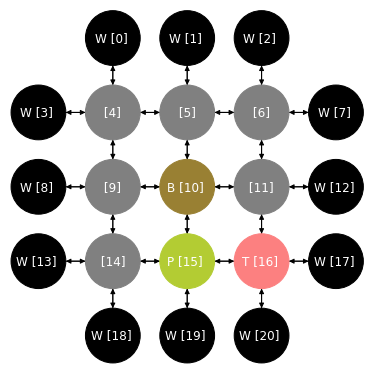

In [23]:
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)

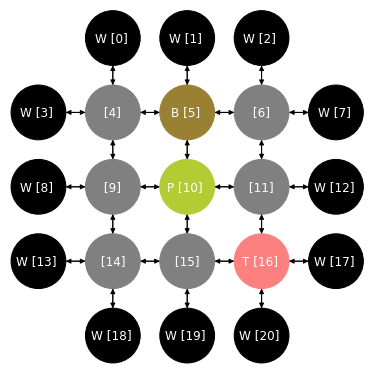

In [25]:
# Up = 0
next_state, reward, done, info = graph_env.step(
    direction_to_node_idx(state, 0)
)
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)
plt.show()

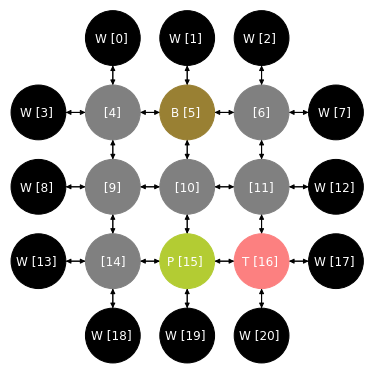

In [26]:
# Down = 1
next_state, reward, done, info = graph_env.step(
    direction_to_node_idx(state, 1)
)
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)
plt.show()

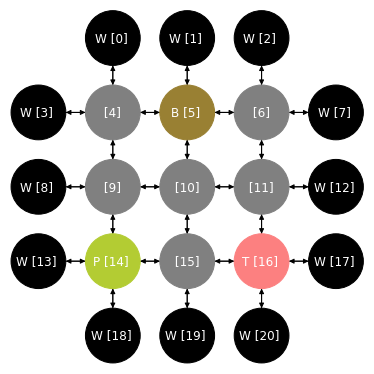

In [27]:
# Left = 2
next_state, reward, done, info = graph_env.step(
    direction_to_node_idx(state, 2)
)
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)
plt.show()

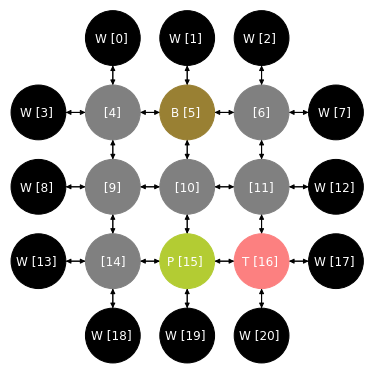

In [28]:
# Right = 3
next_state, reward, done, info = graph_env.step(
    direction_to_node_idx(state, 3)
)
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)
plt.show()

## Training

In [90]:
# Class containing all the options: only for notebook purpose, 
# otherwise contained in a parser
class Options:
    def __init__(self):
        self.train_path = "../levels/dummy_10/test"
        self.test_path = "../levels/dummy_10/test"
        self.target_update = 10
        self.gamma = 1.0
        self.eps_max = 1.0
        self.eps_min = 0.1
        self.eps_stop_step = 3000
        self.batch_size = 32
        self.buffer_size = 5000
        self.max_steps = 25
        self.max_steps_eval = 25
        self.epochs = 100
        self.seed = 123
        self.walls_prob = 0
        self.static_prob = 0
        self.lr = 0.0025
        self.rms_alpha = 0.95
        self.rms_eps = 0.01
        self.no_clamp_gradient = False
        self.early_stop_deadlocks = False
        self.no_penalize_deadlocks = True
        self.go_back_after_deadlocks = False
        self.reward_deadlocks = -1

        self.embedding = DirectionalPositionalEmbedding()
        self.training_id = str(int(time.time()))
    

opt = EasyDict(Options().__dict__)

In [91]:
trainer = QLearningGraphCenteredTrainer(opt)

PARAMETERS SUMMARY
train_path: ../levels/dummy_10/test
test_path: ../levels/dummy_10/test
target_update: 10
gamma: 1.0
eps_max: 1.0
eps_min: 0.1
eps_stop_step: 3000
batch_size: 32
buffer_size: 5000
max_steps: 25
max_steps_eval: 25
epochs: 100
seed: 123
walls_prob: 0
static_prob: 0
lr: 0.0025
rms_alpha: 0.95
rms_eps: 0.01
no_clamp_gradient: False
early_stop_deadlocks: False
no_penalize_deadlocks: True
go_back_after_deadlocks: False
reward_deadlocks: -1
embedding: <data.embedding.DirectionalPositionalEmbedding object at 0x7f70c02079e8>
training_id: 1578141920
====
INFO
====
train_size: 1
test_size: 1
scheduler: <class 'rl.schedulers.AnnealingScheduler'>


In [92]:
# Model for target network
print(trainer.target_net)

GraphCenteredNet(
  (conv_e): EdgeConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (conv_c1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (conv_c2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [93]:
monitor = ['solved', 'mean_cum_reward', 'time elapsed', 'mean_loss']
history = {name: [] for name in monitor}

for epoch in range(opt.epochs):
    epoch_info = trainer.train_one_epoch()
    trainer.eval_one_epoch()
    
    for name in monitor:
        history[name].append(epoch_info[name])

print("training done in {}".format(sum(history["time elapsed"])))

EPOCH 0
mean_cum_reward[train]: -1.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 1.0
time elapsed[train]: 0.0345
mean_loss[train]: 0.0
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 1
mean_cum_reward[train]: -1.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.9925
time elapsed[train]: 0.3099
mean_loss[train]: 1.3808
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 2
mean_cum_reward[train]: -1.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.985
time elapsed[train]: 0.3981
mean_loss[train]: 1.4547
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 3
mean_cum_reward[train]: 10.5
solved[train]: 1
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.9775
time elapsed[train]: 0.2413
mean_loss[train]: 3.9197
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 4
mean_cum_reward[train]: -2.5
solved[train]:

mean_cum_reward[train]: -1.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.823
time elapsed[train]: 0.4219
mean_loss[train]: 5.0721
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 25
mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.8155
time elapsed[train]: 0.4253
mean_loss[train]: 6.7431
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 26
mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.808
time elapsed[train]: 0.4224
mean_loss[train]: 4.3668
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 27
mean_cum_reward[train]: -1.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.8005
time elapsed[train]: 0.4229
mean_loss[train]: 5.1074
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 28
mean_cum_reward[train]: 11.1
solved[train]

mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.6526
time elapsed[train]: 0.4322
mean_loss[train]: 9.5606
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 49
mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.6451
time elapsed[train]: 0.4358
mean_loss[train]: 7.9646
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 50
mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.6376
time elapsed[train]: 0.4328
mean_loss[train]: 7.4093
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 51
mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.6301
time elapsed[train]: 0.4287
mean_loss[train]: 6.7583
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 52
mean_cum_reward[train]: -2.5
solved[trai

mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.4726
time elapsed[train]: 0.4294
mean_loss[train]: 5.4927
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 73
mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.4651
time elapsed[train]: 0.4148
mean_loss[train]: 6.5784
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 74
mean_cum_reward[train]: -1.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.4576
time elapsed[train]: 0.43
mean_loss[train]: 7.7067
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 75
mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.4501
time elapsed[train]: 0.4519
mean_loss[train]: 6.6247
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 76
mean_cum_reward[train]: -2.5
solved[train]

mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.2926
time elapsed[train]: 0.4303
mean_loss[train]: 4.4895
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 97
mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.2851
time elapsed[train]: 0.4424
mean_loss[train]: 4.5763
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 98
mean_cum_reward[train]: -1.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.2776
time elapsed[train]: 0.4462
mean_loss[train]: 3.8527
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 99
mean_cum_reward[train]: -2.5
solved[train]: 0
deadlocks[train]: 0
dataset size[train]: 1
epsilon[train]: 0.2701
time elapsed[train]: 0.4334
mean_loss[train]: 2.7429
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1


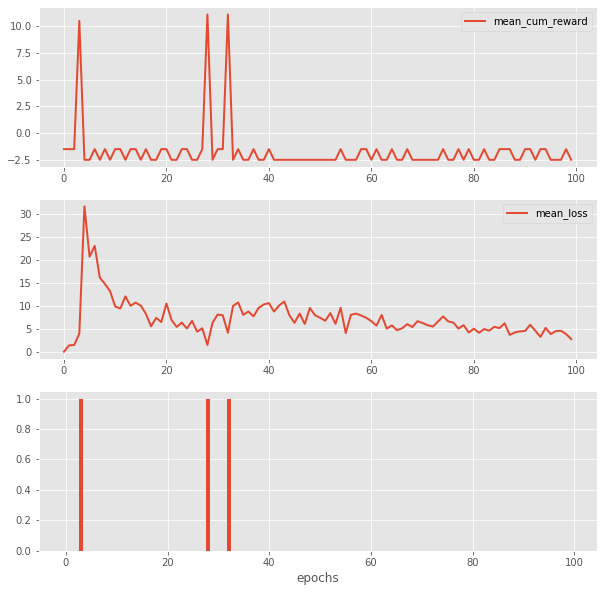

In [94]:
plt.style.use('ggplot')

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(history["mean_cum_reward"], lw=2, label='mean_cum_reward')
axes[0].legend()
axes[1].plot(history["mean_loss"], lw=2, label='mean_loss')
axes[1].legend()
axes[2].bar(range(opt.epochs), history["solved"])
axes[2].set_xlabel('epochs')

plt.show()